# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

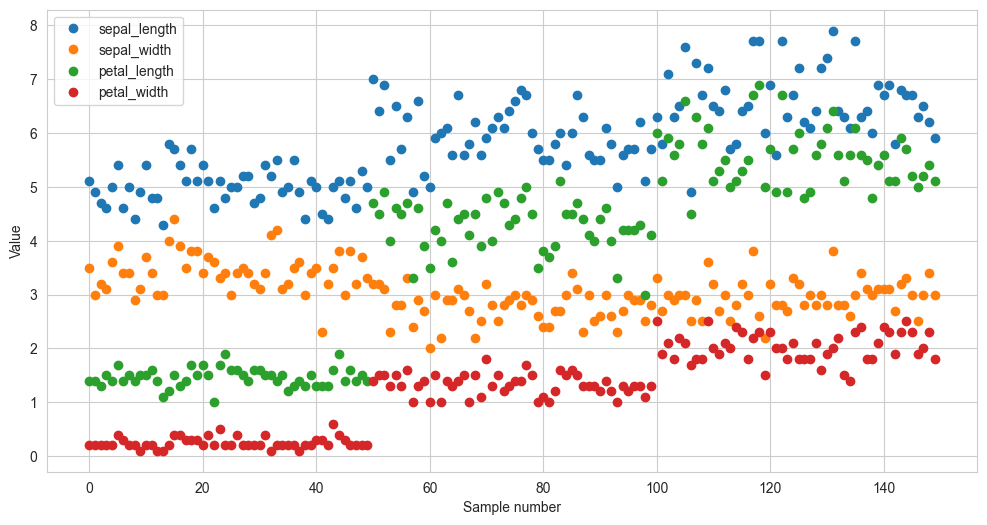

In [3]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [4]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
## REMOVED BECAUSE WE UPDATE DYNAMICALLY
# batchsize    = 16
# train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Construct the model and training plans

In [26]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris,lossfun,optimizer

In [34]:
# train the model

# global parameter
numepochs = 500

# Does not change, so only compute once.
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

def trainTheModel(batch_size: int):

  # Load data with specific batch size
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():         # Dont comupte gradients (no backprop, saves time)
      predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# Test it out

Loading data into batches...
Done!


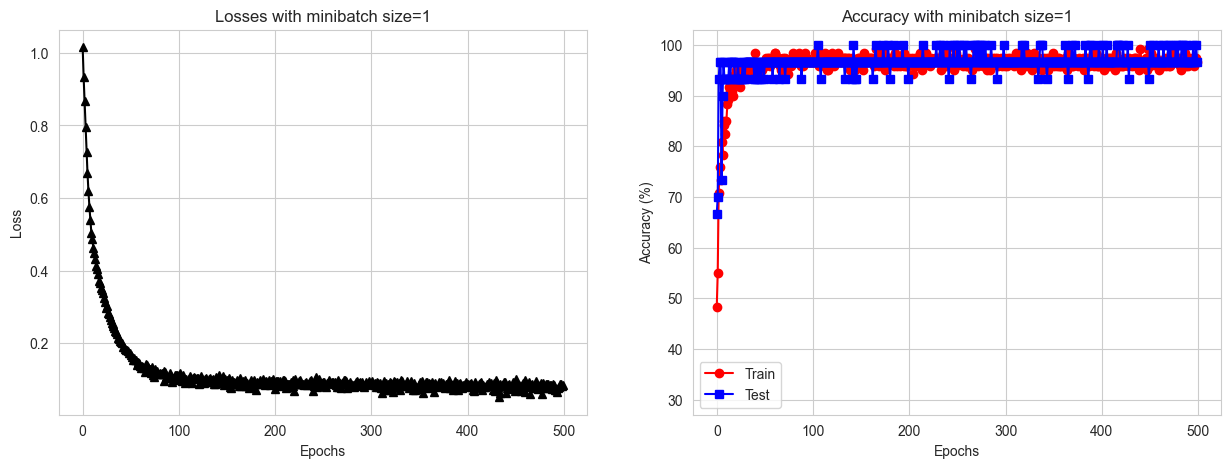

In [33]:
## First test a single run!
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel(1)

# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=1')

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=1')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

In [29]:
batch_sizes = [ 2**N for N in range(0, 7)]

all_train_acc = []
all_test_acc = []
all_losses = []

for bs in batch_sizes:
  print(f"Testing for batch size {bs}...")

  # create a model
  ANNiris,lossfun,optimizer = createANewModel()

  # train the model
  trainAcc,testAcc,losses = trainTheModel(bs)

  all_train_acc.append(trainAcc)
  all_test_acc.append(testAcc)
  all_losses.append(losses)

Testing for batch size 1...
Loading data into batches...
Done!
Testing for batch size 2...
Loading data into batches...
Done!
Testing for batch size 4...
Loading data into batches...
Done!
Testing for batch size 8...
Loading data into batches...
Done!
Testing for batch size 16...
Loading data into batches...
Done!
Testing for batch size 32...
Loading data into batches...
Done!
Testing for batch size 64...
Loading data into batches...
Done!


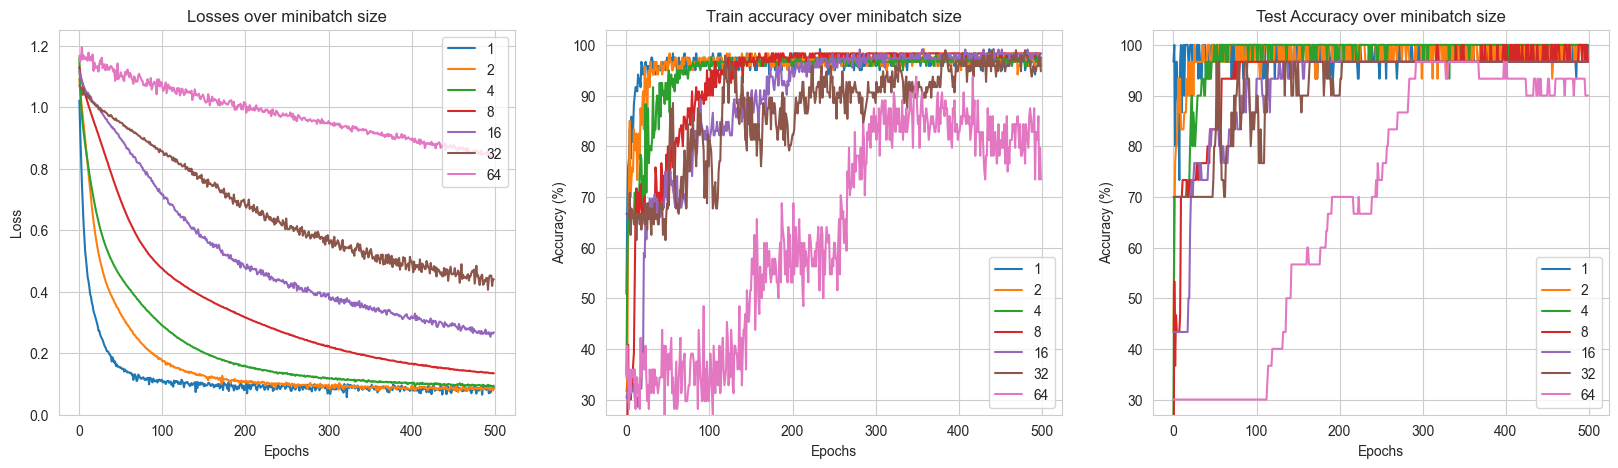

In [30]:
# plot the results
fig,ax = plt.subplots(1,3, figsize=(20,5))


ax[0].plot(np.transpose(all_losses), label=batch_sizes)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses over minibatch size')
ax[0].legend()

ax[1].plot(np.transpose(all_train_acc), label=batch_sizes)
ax[1].set_title('Train accuracy over minibatch size')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])
ax[1].legend()

ax[2].plot(np.transpose(all_test_acc), label=batch_sizes)
ax[2].set_title('Test Accuracy over minibatch size')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].legend(['Train','Test'])
ax[2].set_ylim([27,103])
ax[2].legend()

plt.show()